# Logistic Regression

### Import Libraries and pull data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, MultiTaskLasso
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# fetch from yahoo
A  = yf.download(['ADBE'], start="2013-12-31", end="2019-12-31" , progress=False)['Adj Close'] #ADBE
B  = yf.download(['SJM'], start="2013-12-31",  end="2019-12-31" , progress=False)['Adj Close']
# write to file
A.to_csv('data/stockdata1.csv')
B.to_csv('data/stockdata2.csv')
# fetch from file
A = pd.read_csv('data/stockdata1.csv', index_col=0, parse_dates=True,infer_datetime_format=True)
B = pd.read_csv('data/stockdata2.csv', index_col=0, parse_dates=True,infer_datetime_format=True)

### Mathematics behind logistic classification

For classification problems, using logistic regression, the sigmoidal function is used to fit the data (1), as this allows for a clear segregation between two classifications (i.e. 0 and 1). 

$$
h(\mathbf{x}) = \frac{ 1 }{ 1 + e ^ {- \mathbf{\theta} ^ {T} \mathbf{x} }} 
\quad\quad \text{(1)} 
$$

<img src="https://miro.medium.com/max/700/1*QY3CSyA4BzAU6sEPFwp9ZQ.png" width=400 />

**FIGURE 1: The Sigmoidal function.**

Logistic regression essentially calculates the probability that a particular set of data resides in either category.


The cost finction represents how far off the prediction is from the observed value, it is therefore a function to be minimised in order to fit the model to the data.
The cost function should have a single minumum, and postitive apart from where there is a perfect fit, in which case it should be 0. Equation 2 satisfies this. When $y = 0$ the cost function is also zero when $h_\theta = 0$, and the case when $y = 1$ the cose function smoothly deacreases to 0 as $h_\theta = 0$ tends to 1.

$$
J(\mathbf{\theta}) = - \frac{1}{N} \sum_{n=1}^{N} \Bigl(y ^ {(n)} ln \Bigl(h_\theta (\mathbf{x} ^ {(n)})\Bigr) + (1 - y ^ {(n)})ln \Bigl(1 - h_\theta (\mathbf{x} ^ {(n)})\Bigr) \Bigr) 
\quad\quad \text{(2)} 
$$

where $N$ is the number of observations, $y ^ {(n)}$ is the actual (observed) value, and $h_\theta (\mathbf{x} ^ {(n)})$ is the predicted value.

In the case of Ridge regression (3), the $L ^ {2}$ norm penalty is included in the cost function. The larger the coefficients, the larger the penalty. The additional term has the effect of reducing the size of the coefficients that contribute most to the error, thereby reducing model complexity.


$$
J(\mathbf{\theta}) = - \frac{1}{N} \sum_{n=1}^{N} \Bigl(y ^ {(n)} ln \Bigl(h_\theta (\mathbf{x} ^ {(n)})\Bigr) + (1 - y ^ {(n)})ln \Bigl(1 - h_\theta (\mathbf{x} ^ {(n)})\Bigr) + \lambda \lvert\mathbf{\bar\theta}\rvert ^ {2} \Bigr) 
\quad\quad \text{(3)} 
$$

where $\lambda$ is the learning rate, and $\bar\theta$ is the vector of coefficients.

For Lasso regression (4) $L ^ {1}$ norm penalty is included in the cost function. This then sets the coefficients, that contribute most to the error, to 0.

$$
J(\mathbf{\theta}) = - \frac{1}{N} \sum_{n=1}^{N} \Bigl(y ^ {(n)} ln \Bigl(h_\theta (\mathbf{x} ^ {(n)})\Bigr) + (1 - y ^ {(n)})ln \Bigl(1 - h_\theta (\mathbf{x} ^ {(n)})\Bigr) + \lambda \lvert\mathbf{\bar\theta}\rvert \Bigr) 
\quad\quad \text{(4)} 
$$


### Define functions

In [2]:
def genfeat(data) :
    '''
    transforms yahoo price data for further processing. 
    calcultaes returns and return sign.
    
    data: price data    
    '''
    cols = []
    d = data.copy()
    
    # rename Adj close
    d.columns = ['price']
    
    # calc return
    d['return'] = np.log(d['price'] / d['price'].shift(1))
    
    # past returns
    for i in range(1, 6):
        col = 'ret_%d' % i
        d[col] = d['return'].shift(i)
        cols.append(col)
        
    # momentum 
    d['m_1'] = d['price'].shift(1) - d['price'].shift(2)
    cols.append('m_1')
    
    d['m_5'] = d['price'].shift(1) - d['price'].shift(6)
    cols.append('m_5')
    
    # 5D moving average
    d['sma'] = d['price'].shift(1).rolling(5).sum() / 5
    cols.append('sma')
    
    # 7D exponential moving average
    d['ema'] = d['price'].ewm(span=7, adjust=False).mean()
    d['ema'] = d['ema'].shift(1)
    cols.append('ema')
    
    # get sign of return
    d['return_sign'] = np.sign(d['return'].values+1e-5)
        
    # remove NaNs and price
    d.dropna(inplace=True)
    d = d.drop(columns="price")
    
    return d, cols


In [3]:
def pltcm(actdata, preddata, title = 'Confusion Matrix') :
    '''
    plot confusion matrix
    
    data: matrix containing 'return_sign' and 'pred'
    title (optional): title for confusion matrix
    '''
    cm = confusion_matrix(actdata,preddata)
    if cm.shape == (3,3):
        temp = pd.DataFrame(cm, index=['-1', '0', '1'], columns=['-1', '0', '1'])    
    else :
        temp = pd.DataFrame(cm, index=['-1', '1'], columns=['-1', '1'])

    sns.heatmap(temp, annot=True, cmap='Blues', fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    
    return plt
    

In [4]:
def plot_logistic_ROC(model, x_test, y_test, x_pop, y_pop, ind):
    '''
    plot ROC
    
    model: model to be used
    x_test: features for test set
    y_test: return sign for test set
    x_pop: features for full population
    y_pop: return sign of full population
    ind: 1 for up moves, 0 for down moves
    '''
    default_ind_name = ['Positive down move', 'Positive up move'] # This is in terms of label for Positives for Roc Curve

    logit_roc_aucT = roc_auc_score(y_test, model.predict(x_test), multi_class = 'ovr') #Here, logit2can run on Test or repeated on Train
    fprT, tprT, thresholdsT = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    logit_roc_aucP = roc_auc_score(y_pop, model.predict(x_pop), multi_class = 'ovr')
    fprP, tprP, thresholdsP = roc_curve(y_pop, model.predict_proba(x_pop)[:,1])
    fig, ax = plt.subplots(figsize=(10,6)) #fig = plt.figure(figsize=(18,10))

    # 1) Plot a diagnoal line of fully random classifier
    ax.plot([0, 1], [0, 1],'r--', label='Random Classifier')

    # 1) Plot ROC Curve for the predictions on Test Dataset
    ax.plot(fprT, tprT, label='Train/Test Regression (area = %0.2f)' % logit_roc_aucT)

    # 1) Plot ROC Curve for the Full Dataset (Population)
    ax.plot(fprP, tprP, label='Population Regression (area = %0.2f)' % logit_roc_aucP)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False ' + default_ind_name[ind] + ' Rate', fontsize=15)
    plt.ylabel('True ' + default_ind_name[ind] + ' Rate', fontsize=15)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

    return ax

In [5]:
def logistic_sigmoid(xb):
    return (1 / (1 + np.exp(-xb)))

In [6]:
# attributes for pipeline
c = 0.1
solver = 'saga'

## Stock 1: 

The first stock selected is that of Adobe inc. (ADBE). The reason for this choice is that it should be an easier one to predict given it generally increasing value with fiarly low volatility. i.e. the model should comfortably predict the up moves of the stock price. Data has been taken from 2013-12-31 to 2019-12-31, the reason being to aviod the "COVID crash" and use data more representative of typical conditions.

### Feature Selection

In [7]:
# generate full feature set
X1, x1feat = genfeat(A)
X1.head()

S:\Program Files\anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sign


,return,ret_1,ret_2,ret_3,ret_4,ret_5,m_1,m_5,sma,ema,return_sign
Date,,,,,,,,,,,
2014-01-09,0.003221,-0.001188,0.014519,-0.017736,-0.002195,-0.009902,-0.070000,-0.980000,58.888,59.094268,1.0
2014-01-10,0.007419,0.003221,-0.001188,0.014519,-0.017736,-0.002195,0.189999,-0.200001,58.848,59.093201,1.0
2014-01-13,-0.015746,0.007419,0.003221,-0.001188,0.014519,-0.017736,0.439999,0.369999,58.922,59.202401,-1.0
2014-01-14,0.029758,-0.015746,0.007419,0.003221,-0.001188,0.014519,-0.930000,0.480000,59.018,59.051800,1.0
2014-01-15,0.021467,0.029758,-0.015746,0.007419,0.003221,-0.001188,1.770000,1.399998,59.298,59.381350,1.0


In [8]:
# score features to determine main contributors
selector1 =  SelectKBest(f_regression, k='all') 
selector1.fit(X1[x1feat],X1['return_sign'])
selector1.get_support(indices=True)
for f, s in zip(x1feat, selector1.scores_):
    print(f'F-score: {s:0.4} for feature {f}')

F-score: 4.206 for feature ret_1
F-score: 2.926 for feature ret_2
F-score: 0.08028 for feature ret_3
F-score: 3.074 for feature ret_4
F-score: 4.782 for feature ret_5
F-score: 6.148 for feature m_1
F-score: 13.62 for feature m_5
F-score: 0.05894 for feature sma
F-score: 0.05358 for feature ema


In [9]:
# limited field set based on top scoring features
x1kbest = ['ret_1', 'ret_5', 'm_1', 'm_5']

In [10]:
# split dataset into train/test sets for both the full set of features and the limited set
X1_train_full, X1_test_full, y1_train_full, y1_test_full = train_test_split(X1[x1feat], X1['return_sign'], test_size=0.2, random_state=0, shuffle=False)
X1_train_lim, X1_test_lim, y1_train_lim, y1_test_lim = train_test_split(X1[x1kbest], X1['return_sign'], test_size=0.2, random_state=0, shuffle=False)
print(f"Full Train and Test Size {len(X1_train_full)}, {len(X1_test_full)}")
print(f"Limited Train and Test Size {len(X1_train_lim)}, {len(X1_test_lim)}")

Full Train and Test Size 1203, 301
Limited Train and Test Size 1203, 301


### Logistic Regression

In [11]:
# base logistic regression pipeline (no penalty)
logpipe1f = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'none', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

logpipe1l = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'none', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

# fit to data
logpipe1f.fit(X1_train_full,y1_train_full)
logpipe1l.fit(X1_train_lim,y1_train_lim)

S:\Program Files\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
S:\Program Files\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 LogisticRegression(C=0.1, max_iter=10000, n_jobs=-1,
                                    penalty='none', solver='saga'))])

In [12]:
#score train and test set prediction
print('Full feature set scores: ')
print('Training data: ', logpipe1f.score(X1_train_full,y1_train_full))
print('Testing data: ', logpipe1f.score(X1_test_full,y1_test_full))
print('\nLimited feature set scores: ')
print('Training data: ', logpipe1l.score(X1_train_lim,y1_train_lim))
print('Testing data: ', logpipe1l.score(X1_test_lim,y1_test_lim))

Full feature set scores: 
Training data:  0.5669160432252701
Testing data:  0.5647840531561462

Limited feature set scores: 
Training data:  0.5627597672485453
Testing data:  0.584717607973422


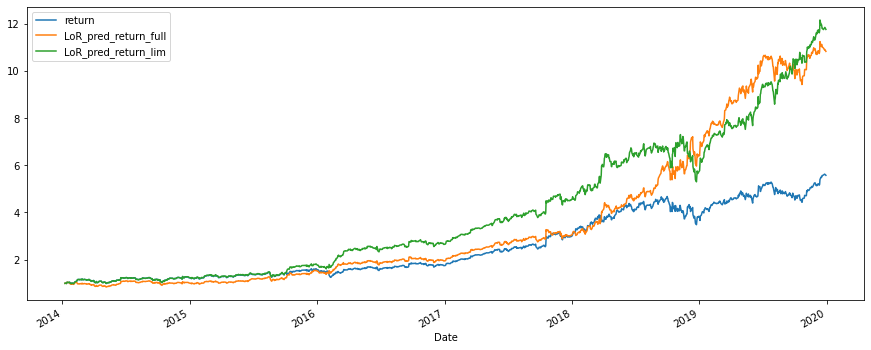

In [13]:
# plot predicted return vs actual return
X1['LoR_pred_full'] = logpipe1f.predict(X1[x1feat])
X1['LoR_pred_lim'] = logpipe1l.predict(X1[x1kbest])
X1['LoR_pred_return_full'] = X1['LoR_pred_full'] * X1['return']
X1['LoR_pred_return_lim'] = X1['LoR_pred_lim'] * X1['return']
X1[['return', 'LoR_pred_return_full', 'LoR_pred_return_lim']].cumsum().apply(np.exp).plot(figsize=(15, 6))

In [14]:
# return coefficients 
print('Full feature set coefficients: ')
print(logpipe1f['regressor'].coef_)
print('\nLimited feature set coefficients: ')
print(logpipe1l['regressor'].coef_)

Full feature set coefficients: 
[[ 0.08057963 -0.07525182 -0.01719067 -0.0884177  -0.07175774 -0.2209084
   0.01173691 -6.8111684   6.8167236 ]]

Limited feature set coefficients: 
[[ 0.07260654 -0.07088357 -0.13577757 -0.1127844 ]]


### Ridge Regression

In [15]:
# logistic regression pipeline with L2 penalty
ridpipe1f = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'l2', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

ridpipe1l = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'l2', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

ridpipe1f.fit(X1_train_full,y1_train_full)
ridpipe1l.fit(X1_train_lim,y1_train_lim)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 LogisticRegression(C=0.1, max_iter=10000, n_jobs=-1,
                                    solver='saga'))])

In [16]:
#score train and test set prediction
print('Full feature set scores: ')
print('Training data: ', ridpipe1f.score(X1_train_full,y1_train_full))
print('Testing data: ', ridpipe1f.score(X1_test_full,y1_test_full))
print('\nLimited feature set scores: ')
print('Training data: ', ridpipe1l.score(X1_train_lim,y1_train_lim))
print('Testing data: ', ridpipe1l.score(X1_test_lim,y1_test_lim))

Full feature set scores: 
Training data:  0.5627597672485453
Testing data:  0.5913621262458472

Limited feature set scores: 
Training data:  0.5610972568578554
Testing data:  0.584717607973422


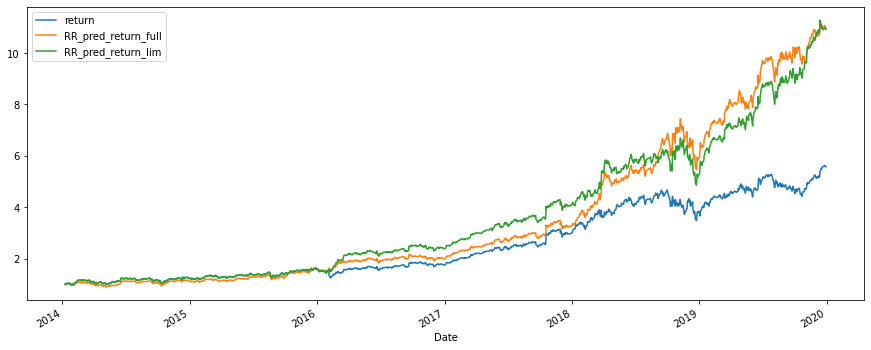

In [17]:
# plot predicted return vs actual return
X1['RR_pred_full'] = ridpipe1f.predict(X1[x1feat])
X1['RR_pred_lim'] = ridpipe1l.predict(X1[x1kbest])
X1['RR_pred_return_full'] = X1['RR_pred_full'] * X1['return']
X1['RR_pred_return_lim'] = X1['RR_pred_lim'] * X1['return']
X1[['return', 'RR_pred_return_full', 'RR_pred_return_lim']].cumsum().apply(np.exp).plot(figsize=(15, 6))

In [18]:
# return coefficients
print('Full feature set coefficients: ')
print(ridpipe1f['regressor'].coef_)
print('\nLimited feature set coefficients: ')
print(ridpipe1l['regressor'].coef_)

Full feature set coefficients: 
[[ 0.04713817 -0.03674929  0.00392737 -0.08270832 -0.09262648 -0.13739438
  -0.04659326 -0.010046    0.01704317]]

Limited feature set coefficients: 
[[ 0.04834048 -0.06971489 -0.11076817 -0.11018877]]


### Lasso Regression

In [19]:
# logistic regression pipeline with L1 penalty
laspipe1f = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'l1', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

laspipe1l = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'l1', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

laspipe1f.fit(X1_train_full,y1_train_full)
laspipe1l.fit(X1_train_lim,y1_train_lim)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 LogisticRegression(C=0.1, max_iter=10000, n_jobs=-1,
                                    penalty='l1', solver='saga'))])

In [20]:
#score train and test set prediction
print('Full feature set scores: ')
print('Training data: ', laspipe1f.score(X1_train_full,y1_train_full))
print('Testing data: ', laspipe1f.score(X1_test_full,y1_test_full))
print('\nLimited feature set scores: ')
print('Training data: ', laspipe1l.score(X1_train_lim,y1_train_lim))
print('Testing data: ', laspipe1l.score(X1_test_lim,y1_test_lim))

Full feature set scores: 
Training data:  0.5602660016625104
Testing data:  0.574750830564784

Limited feature set scores: 
Training data:  0.5619285120532004
Testing data:  0.574750830564784


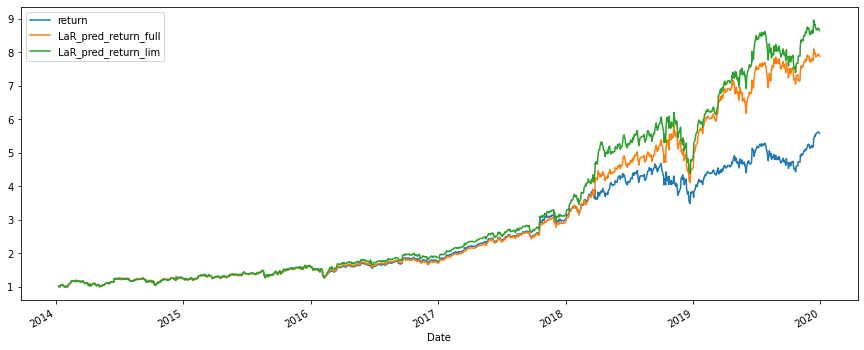

In [21]:
# plot predicted return vs actual return
X1['LaR_pred_full'] = laspipe1f.predict(X1[x1feat])
X1['LaR_pred_lim'] = laspipe1l.predict(X1[x1kbest])
X1['LaR_pred_return_full'] = X1['LaR_pred_full'] * X1['return']
X1['LaR_pred_return_lim'] = X1['LaR_pred_lim'] * X1['return']
X1[['return', 'LaR_pred_return_full', 'LaR_pred_return_lim']].cumsum().apply(np.exp).plot(figsize=(15, 6))

In [22]:
# return coefficients
print('Full feature set coefficients: ')
print(laspipe1f['regressor'].coef_)
print('\nLimited feature set coefficients: ')
print(laspipe1l['regressor'].coef_)

Full feature set coefficients: 
[[ 0.          0.          0.         -0.03735876 -0.04840857 -0.04623257
  -0.07988547  0.          0.        ]]

Limited feature set coefficients: 
[[ 0.         -0.03997123 -0.03719581 -0.10200317]]


### Impact on coefficients

In [23]:
fcoefdf1 = pd.DataFrame({'None':logpipe1f['regressor'].coef_.flatten(), 'L1':laspipe1f['regressor'].coef_.flatten(), 'L2':ridpipe1f['regressor'].coef_.flatten()})

print('Full feature set coefficients: ')
fcoefdf1

Full feature set coefficients: 


,None,L1,L2
0,0.080580,0.000000,0.047138
1,-0.075252,0.000000,-0.036749
2,-0.017191,0.000000,0.003927
3,-0.088418,-0.037359,-0.082708
4,-0.071758,-0.048409,-0.092626
5,-0.220908,-0.046233,-0.137394
6,0.011737,-0.079885,-0.046593
7,-6.811168,0.000000,-0.010046
8,6.816724,0.000000,0.017043


In [24]:
lcoefdf1 = pd.DataFrame({'None':logpipe1l['regressor'].coef_.flatten(), 'L1':laspipe1l['regressor'].coef_.flatten(), 'L2':ridpipe1l['regressor'].coef_.flatten()})

print('Limited feature set coefficients: ')
lcoefdf1

Limited feature set coefficients: 


,None,L1,L2
0,0.072607,0.000000,0.048340
1,-0.070884,-0.039971,-0.069715
2,-0.135778,-0.037196,-0.110768
3,-0.112784,-0.102003,-0.110189


As expected, the L1 norm has set the coeffcients to 0 where the L2 norm reduced their contribution. Interestingly, in both cases the weighting for the previous days return is not seen as having much impact on the following days return sign, suggesting the 5 day return and 5 day momentum is a more significant indicator.

### Predicition quality

In [25]:
X1.tail(10)
#X1.to_csv('data/x1.csv')

,return,ret_1,ret_2,ret_3,ret_4,ret_5,m_1,m_5,sma,ema,...,LoR_pred_return_full,LoR_pred_return_lim,RR_pred_full,RR_pred_lim,RR_pred_return_full,RR_pred_return_lim,LaR_pred_full,LaR_pred_lim,LaR_pred_return_full,LaR_pred_return_lim
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-16,0.018263,0.038408,0.007282,-0.001415,-0.009424,0.002674,11.980011,11.709991,307.771997,308.145397,...,-0.018263,-0.018263,-1.0,-1.0,-0.018263,-0.018263,-1.0,-1.0,-0.018263,-0.018263
2019-12-17,-0.002938,0.018263,0.038408,0.007282,-0.001415,-0.009424,5.859985,16.750000,311.121997,312.059045,...,0.002938,0.002938,-1.0,-1.0,0.002938,0.002938,-1.0,-1.0,0.002938,0.002938
2019-12-18,0.004728,-0.002938,0.018263,0.038408,0.007282,-0.001415,-0.949982,18.679993,314.857996,314.756785,...,0.004728,-0.004728,1.0,-1.0,0.004728,-0.004728,-1.0,-1.0,-0.004728,-0.004728
2019-12-19,0.009969,0.004728,-0.002938,0.018263,0.038408,0.007282,1.529999,20.640015,318.985999,317.162590,...,-0.009969,-0.009969,-1.0,-1.0,-0.009969,-0.009969,-1.0,-1.0,-0.009969,-0.009969
2019-12-20,-0.000061,0.009969,0.004728,-0.002938,0.018263,0.038408,3.250000,21.670013,323.320001,319.779444,...,0.000061,0.000061,-1.0,-1.0,0.000061,0.000061,-1.0,-1.0,0.000061,0.000061
2019-12-23,0.004082,-0.000061,0.009969,0.004728,-0.002938,0.018263,-0.020020,9.669983,325.253998,321.737079,...,-0.004082,-0.004082,1.0,-1.0,0.004082,-0.004082,1.0,-1.0,0.004082,-0.004082
2019-12-24,0.002095,0.004082,-0.000061,0.009969,0.004728,-0.002938,1.340027,5.150024,326.284003,323.540312,...,-0.002095,0.002095,1.0,1.0,0.002095,0.002095,1.0,1.0,0.002095,0.002095
2019-12-26,0.004721,0.002095,0.004082,-0.000061,0.009969,0.004728,0.690002,6.790009,327.642004,325.065238,...,-0.004721,0.004721,1.0,1.0,0.004721,0.004721,1.0,1.0,0.004721,0.004721
2019-12-27,-0.001239,0.004721,0.002095,0.004082,-0.000061,0.009969,1.559998,6.820007,329.006006,326.598932,...,0.001239,0.001239,1.0,-1.0,-0.001239,0.001239,1.0,1.0,-0.001239,-0.001239


In [26]:
# generata classification reports
print('Logistic regresson with full feature set: ')
print(classification_report(X1['LoR_pred_full'], X1['return_sign']))
print('Logistic regresson with limited feature set: ')
print(classification_report(X1['LoR_pred_lim'], X1['return_sign']))
print('Ridge regression with full feature set: ')
print(classification_report(X1['RR_pred_full'], X1['return_sign']))
print('Ridge regression with limited feature set: ')
print(classification_report(X1['RR_pred_lim'], X1['return_sign']))
print('Lasso regression with full feature set: ')
print(classification_report(X1['LaR_pred_full'], X1['return_sign']))
print('Lasso regression with limited feature set: ')
print(classification_report(X1['LaR_pred_lim'], X1['return_sign']))

Logistic regresson with full feature set: 
              precision    recall  f1-score   support

        -1.0       0.15      0.54      0.23       185
         1.0       0.90      0.57      0.70      1319

    accuracy                           0.57      1504
   macro avg       0.52      0.56      0.47      1504
weighted avg       0.81      0.57      0.64      1504

Logistic regresson with limited feature set: 
              precision    recall  f1-score   support

        -1.0       0.13      0.55      0.21       162
         1.0       0.91      0.57      0.70      1342

    accuracy                           0.57      1504
   macro avg       0.52      0.56      0.46      1504
weighted avg       0.83      0.57      0.65      1504

Ridge regression with full feature set: 
              precision    recall  f1-score   support

        -1.0       0.14      0.55      0.22       164
         1.0       0.91      0.57      0.70      1340

    accuracy                           0.57      150

note:
with $tp$ as "true positive", $fp$ as "false positive", and $fn$ as "false negative"

$$
Precision = \frac{tp}{tp + fp}
$$
i.e. fraction of positives that are truely positive


$$
Recall = \frac{tp}{tp + fn}
$$
i.e. fraction if positives correclty identified

X1 (full) Logistic Regression ROC plots:


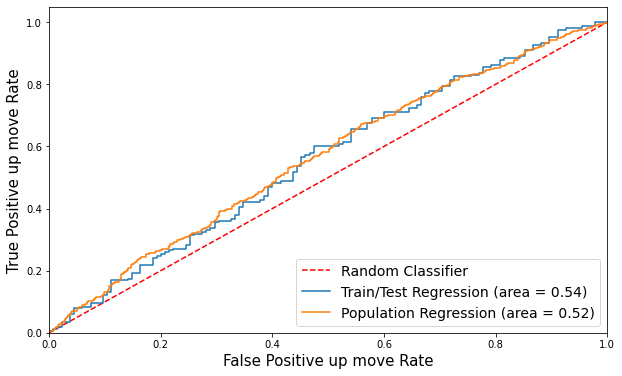

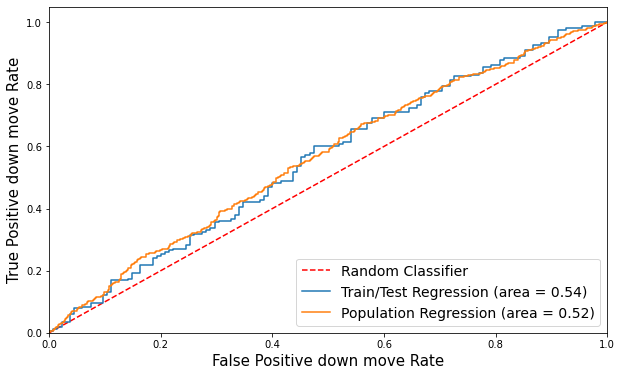

X1 (limited) Logistic Regression ROC plots:


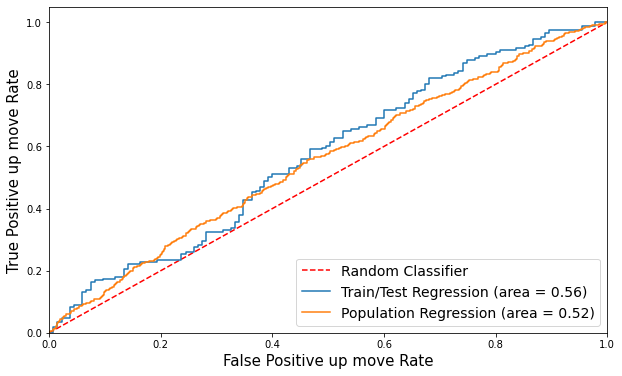

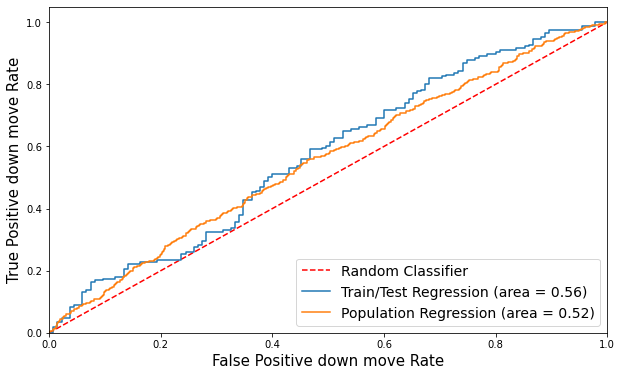

X1 (full) Ridge Regression ROC plots:


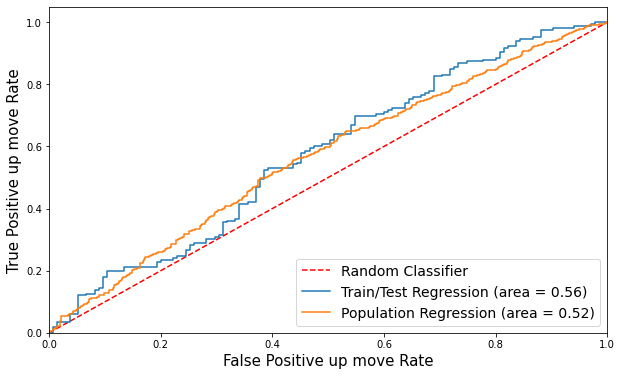

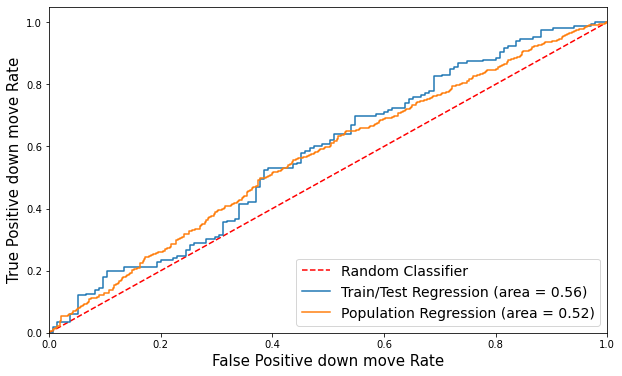

X1 (limited) Ridge Regression ROC plots:


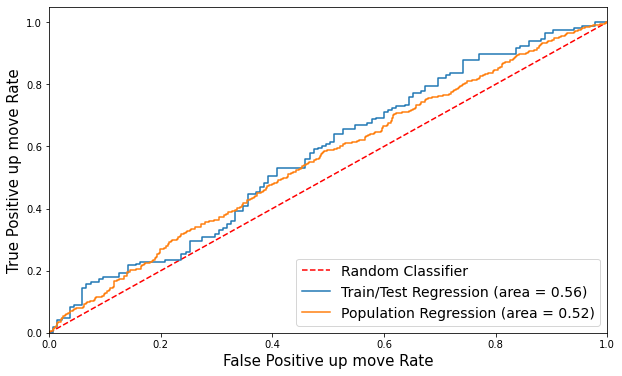

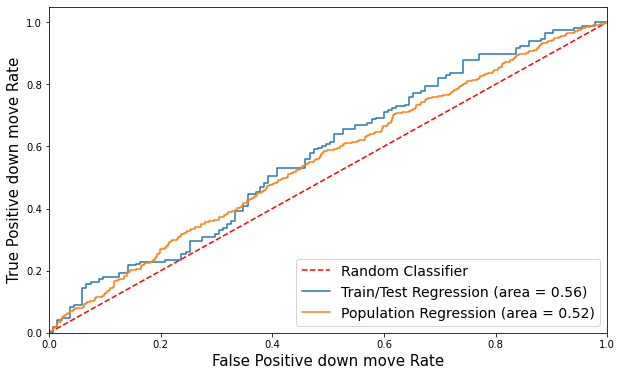

X1 (full) Lasso Regression ROC plots:


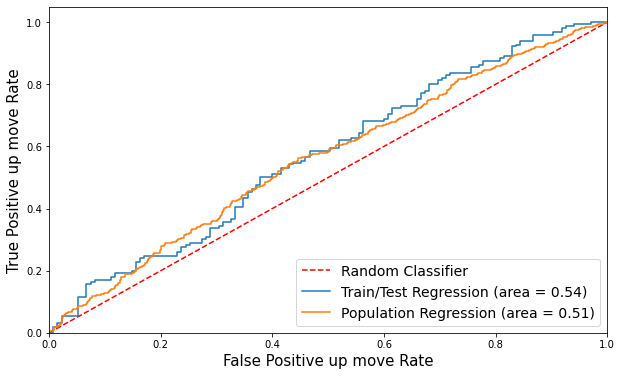

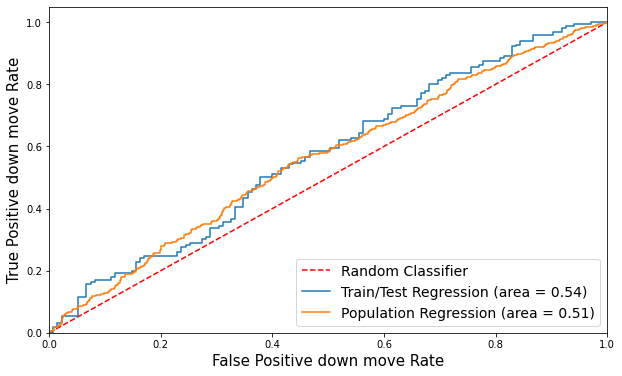

X1 (limited) Lasso Regression ROC plots:


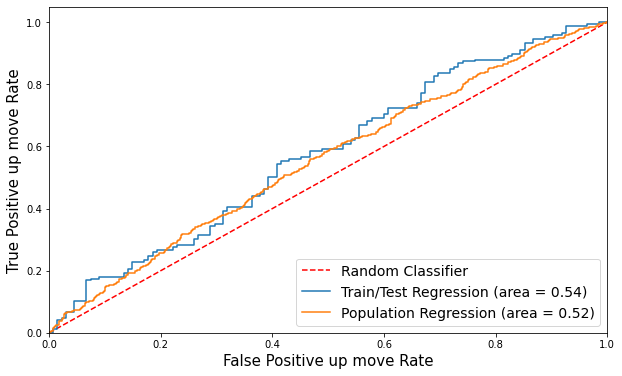

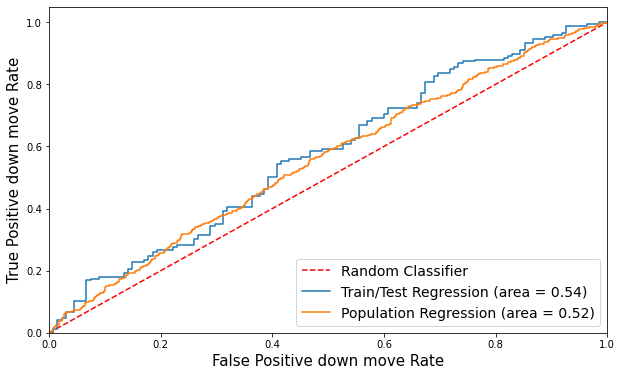

In [27]:
print('X1 (full) Logistic Regression ROC plots:')
plot_logistic_ROC(logpipe1f, X1_test_full, y1_test_full, X1[x1feat], X1['return_sign'], 1)
plot_logistic_ROC(logpipe1f, X1_test_full, y1_test_full, X1[x1feat], X1['return_sign'], 0)
print('X1 (limited) Logistic Regression ROC plots:')
plot_logistic_ROC(logpipe1l, X1_test_lim, y1_test_lim, X1[x1kbest], X1['return_sign'], 1)
plot_logistic_ROC(logpipe1l, X1_test_lim, y1_test_lim, X1[x1kbest], X1['return_sign'], 0)
print('X1 (full) Ridge Regression ROC plots:')
plot_logistic_ROC(ridpipe1f, X1_test_full, y1_test_full, X1[x1feat], X1['return_sign'], 1)
plot_logistic_ROC(ridpipe1f, X1_test_full, y1_test_full, X1[x1feat], X1['return_sign'], 0)
print('X1 (limited) Ridge Regression ROC plots:')
plot_logistic_ROC(ridpipe1l, X1_test_lim, y1_test_lim, X1[x1kbest], X1['return_sign'], 1)
plot_logistic_ROC(ridpipe1l, X1_test_lim, y1_test_lim, X1[x1kbest], X1['return_sign'], 0)
print('X1 (full) Lasso Regression ROC plots:')
plot_logistic_ROC(laspipe1f, X1_test_full, y1_test_full, X1[x1feat], X1['return_sign'], 1)
plot_logistic_ROC(laspipe1f, X1_test_full, y1_test_full, X1[x1feat], X1['return_sign'], 0)
print('X1 (limited) Lasso Regression ROC plots:')
plot_logistic_ROC(laspipe1l, X1_test_lim, y1_test_lim, X1[x1kbest], X1['return_sign'], 1)
plot_logistic_ROC(laspipe1l, X1_test_lim, y1_test_lim, X1[x1kbest], X1['return_sign'], 0)

(1)


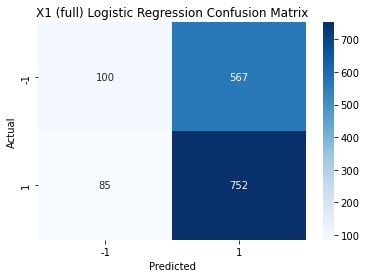

(2)


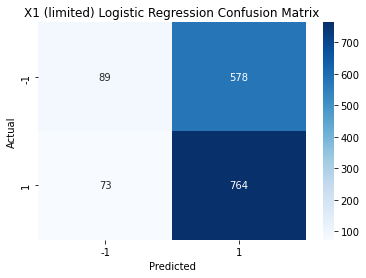

(3)


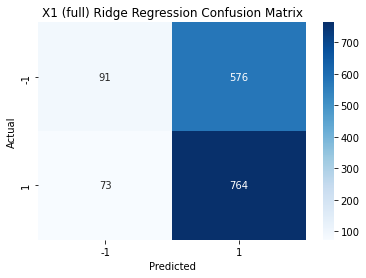

(4)


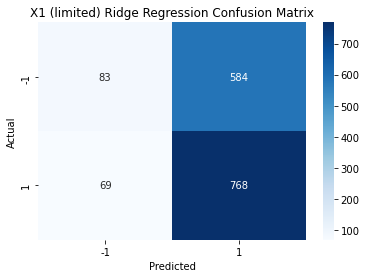

(5)


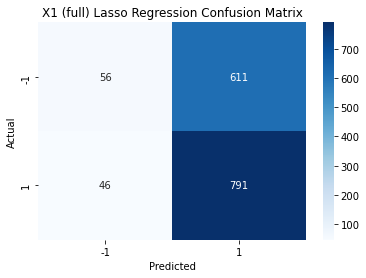

(6)


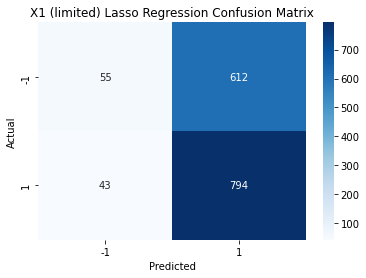

<module 'matplotlib.pyplot' from 'S:\\Program Files\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [28]:
# plot confusion matricies
print('(1)')
pltcm(X1['return_sign'],X1['LoR_pred_full'], 'X1 (full) Logistic Regression Confusion Matrix')
print('(2)')
pltcm(X1['return_sign'],X1['LoR_pred_lim'], 'X1 (limited) Logistic Regression Confusion Matrix')
print('(3)')
pltcm(X1['return_sign'],X1['RR_pred_full'], 'X1 (full) Ridge Regression Confusion Matrix')
print('(4)')
pltcm(X1['return_sign'],X1['RR_pred_lim'], 'X1 (limited) Ridge Regression Confusion Matrix')
print('(5)')
pltcm(X1['return_sign'],X1['LaR_pred_full'], 'X1 (full) Lasso Regression Confusion Matrix')
print('(6)')
pltcm(X1['return_sign'],X1['LaR_pred_lim'], 'X1 (limited) Lasso Regression Confusion Matrix')

### Findings

From the return plots, all types out perform the stock price regardless of the penalty used. This is likely due to the upward trend of the stock with low volatility, so an upward prediction is correct more often than not. However when we look into the confusion matricies and ROC plots it becomes clear that the vast majority of predictions are for upward moves but are only slightly better than a "random classifier". Even the best performing model (ridge regression) only had an accuracy of 0.57 (both with the full and limited feature sets), so is only marginally better than flipping a coin.
This could suggest the features chosen are not suffient to predict the following day's direction, or that the direction itself is effectively random - with the model picking up on the longer term trend to generate better returns.


## Stock 2:

The second stock selected is that of J. M. Smucker Co. (SJM). This stock has been quite volatile over the past 5 years and has been generally downward trending. This should test how well the model is able to predict downward moves and handle high volatility. Data has been taken from 2013-12-31 to 2019-12-31, the reason being to aviod the "COVID crash" and use data more representative of typical conditions.

### Feature Selection

In [29]:
# generate full feature set
X2, x2feat = genfeat(B)
X2.head()

S:\Program Files\anaconda\lib\site-packages\ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in sign


,return,ret_1,ret_2,ret_3,ret_4,ret_5,m_1,m_5,sma,ema,return_sign
Date,,,,,,,,,,,
2014-01-09,-0.001937,-0.033555,0.006126,-0.006027,-0.005110,-0.015463,-2.785789,-4.532089,83.844524,84.099760,-1.0
2014-01-10,0.004481,-0.001937,-0.033555,0.006126,-0.006027,-0.005110,-0.157990,-3.367905,83.170943,83.444283,1.0
2014-01-13,-0.010520,0.004481,-0.001937,-0.033555,0.006126,-0.006027,0.365891,-2.569588,82.657025,83.044148,-1.0
2014-01-14,0.019825,-0.010520,0.004481,-0.001937,-0.033555,0.006126,-0.856522,-2.918839,82.073257,82.529916,1.0
2014-01-15,-0.006565,0.019825,-0.010520,0.004481,-0.001937,-0.033555,1.621574,-1.812836,81.710690,82.549636,-1.0


In [30]:
# score features to determine main contributors
selector2 =  SelectKBest(f_regression, k='all') 
selector2.fit(X2[x2feat],X2['return_sign'])
selector2.get_support(indices=True)
for f, s in zip(x2feat, selector2.scores_):
    print(f'F-score: {s:0.4} for feature {f}')

F-score: 0.4387 for feature ret_1
F-score: 0.3421 for feature ret_2
F-score: 5.968 for feature ret_3
F-score: 0.7917 for feature ret_4
F-score: 4.199 for feature ret_5
F-score: 0.4281 for feature m_1
F-score: 1.312 for feature m_5
F-score: 0.3322 for feature sma
F-score: 0.39 for feature ema


In [31]:
# limited field set based on top scoring features
x2kbest = ['ret_3', 'ret_5', 'm_5']

In [32]:
# split dataset into train/test sets for both the full set of features and the limited set
X2_train_full, X2_test_full, y2_train_full, y2_test_full = train_test_split(X2[x2feat], X2['return_sign'], test_size=0.2, random_state=0, shuffle=False)
X2_train_lim, X2_test_lim, y2_train_lim, y2_test_lim = train_test_split(X2[x2kbest], X2['return_sign'], test_size=0.2, random_state=0, shuffle=False)
print(f"Full Train and Test Size {len(X2_train_full)}, {len(X2_test_full)}")
print(f"Limited Train and Test Size {len(X2_train_lim)}, {len(X2_test_lim)}")

Full Train and Test Size 1203, 301
Limited Train and Test Size 1203, 301


### Logistic Regression

In [33]:
# base logistic regression pipeline (no penalty)
logpipe2f = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'none', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

logpipe2l = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'none', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

# fit to data
logpipe2f.fit(X2_train_full,y2_train_full)
logpipe2l.fit(X2_train_lim,y2_train_lim)

S:\Program Files\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
S:\Program Files\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1321: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 LogisticRegression(C=0.1, max_iter=10000, n_jobs=-1,
                                    penalty='none', solver='saga'))])

In [34]:
#score train and test set prediction
print('Full feature set scores: ')
print('Training data: ', logpipe2f.score(X2_train_full,y2_train_full))
print('Testing data: ', logpipe2f.score(X2_test_full,y2_test_full))
print('\nLimited feature set scores: ')
print('Training data: ', logpipe2l.score(X2_train_lim,y2_train_lim))
print('Testing data: ', logpipe2l.score(X2_test_lim,y2_test_lim))

Full feature set scores: 
Training data:  0.516209476309227
Testing data:  0.4750830564784053

Limited feature set scores: 
Training data:  0.5328345802161264
Testing data:  0.5182724252491694


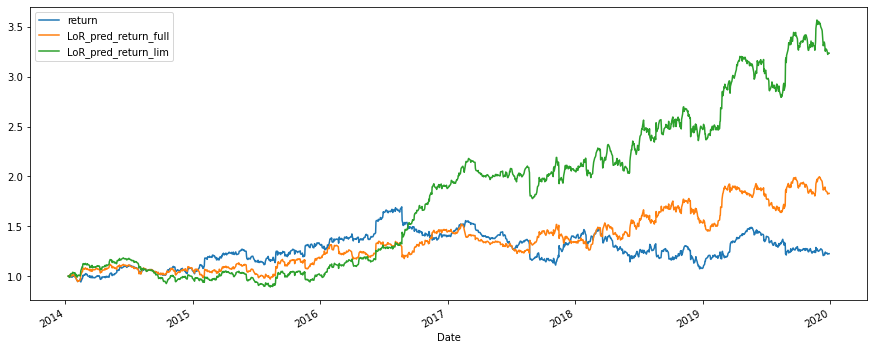

In [35]:
# plot predicted return vs actual return
X2['LoR_pred_full'] = logpipe2f.predict(X2[x2feat])
X2['LoR_pred_lim'] = logpipe2l.predict(X2[x2kbest])
X2['LoR_pred_return_full'] = X2['LoR_pred_full'] * X2['return']
X2['LoR_pred_return_lim'] = X2['LoR_pred_lim'] * X2['return']
X2[['return', 'LoR_pred_return_full', 'LoR_pred_return_lim']].cumsum().apply(np.exp).plot(figsize=(15, 6))

In [36]:
# return coefficients 
print('Full feature set coefficients: ')
print(logpipe2f['regressor'].coef_)
print('\nLimited feature set coefficients: ')
print(logpipe2l['regressor'].coef_)

Full feature set coefficients: 
[[-0.34198277 -0.30114737 -0.35480206 -0.26279718 -0.08727714  0.05712072
   0.5696462  -2.21007605  2.17488116]]

Limited feature set coefficients: 
[[-0.0806975   0.14036515 -0.0388275 ]]


### Ridge Regression

In [37]:
# logistic regression pipeline with L2 penalty
ridpipe2f = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'l2', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

ridpipe2l = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'l2', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

ridpipe2f.fit(X2_train_full,y2_train_full)
ridpipe2l.fit(X2_train_lim,y2_train_lim)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 LogisticRegression(C=0.1, max_iter=10000, n_jobs=-1,
                                    solver='saga'))])

In [38]:
#score train and test set prediction
print('Full feature set scores: ')
print('Training data: ', ridpipe2f.score(X2_train_full,y2_train_full))
print('Testing data: ', ridpipe2f.score(X2_test_full,y2_test_full))
print('\nLimited feature set scores: ')
print('Training data: ', ridpipe2l.score(X2_train_lim,y2_train_lim))
print('Testing data: ', ridpipe2l.score(X2_test_lim,y2_test_lim))

Full feature set scores: 
Training data:  0.5278470490440565
Testing data:  0.5083056478405316

Limited feature set scores: 
Training data:  0.5320033250207814
Testing data:  0.5182724252491694


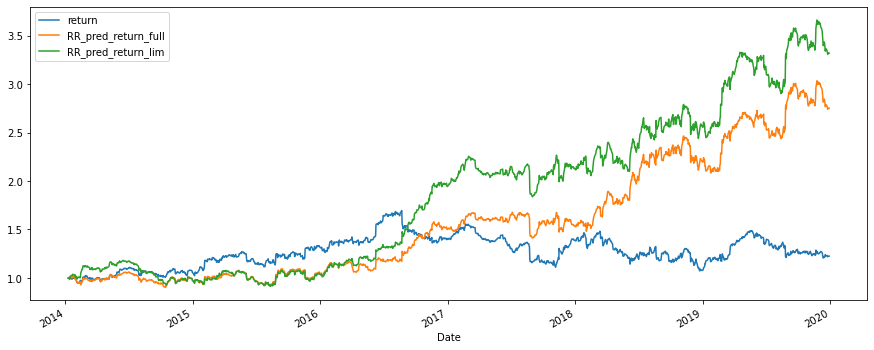

In [39]:
# plot predicted return vs actual return
X2['RR_pred_full'] = ridpipe2f.predict(X2[x2feat])
X2['RR_pred_lim'] = ridpipe2l.predict(X2[x2kbest])
X2['RR_pred_return_full'] = X2['RR_pred_full'] * X2['return']
X2['RR_pred_return_lim'] = X2['RR_pred_lim'] * X2['return']
X2[['return', 'RR_pred_return_full', 'RR_pred_return_lim']].cumsum().apply(np.exp).plot(figsize=(15, 6))

In [40]:
# return coefficients
print('Full feature set coefficients: ')
print(ridpipe2f['regressor'].coef_)
print('\nLimited feature set coefficients: ')
print(ridpipe2l['regressor'].coef_)

Full feature set coefficients: 
[[-0.07202298 -0.06481081 -0.12802601 -0.05694061  0.08648213  0.02530857
   0.07532561 -0.03471357  0.00394846]]

Limited feature set coefficients: 
[[-0.07948369  0.13436504 -0.0356503 ]]


### Lasso Regression

In [41]:
# logistic regression pipeline with L1 penalty
laspipe2f = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'l1', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

laspipe2l = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LogisticRegression(penalty = 'l1', solver = solver, C = c, n_jobs=-1, max_iter = 10000))
])

laspipe2f.fit(X2_train_full,y2_train_full)
laspipe2l.fit(X2_train_lim,y2_train_lim)

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 LogisticRegression(C=0.1, max_iter=10000, n_jobs=-1,
                                    penalty='l1', solver='saga'))])

In [42]:
#score train and test set prediction
print('Full feature set scores: ')
print('Training data: ', laspipe2f.score(X2_train_full,y2_train_full))
print('Testing data: ', laspipe2f.score(X2_test_full,y2_test_full))
print('\nLimited feature set scores: ')
print('Training data: ', laspipe2l.score(X2_train_lim,y2_train_lim))
print('Testing data: ', laspipe2l.score(X2_test_lim,y2_test_lim))

Full feature set scores: 
Training data:  0.5394846217788861
Testing data:  0.53156146179402

Limited feature set scores: 
Training data:  0.5394846217788861
Testing data:  0.53156146179402


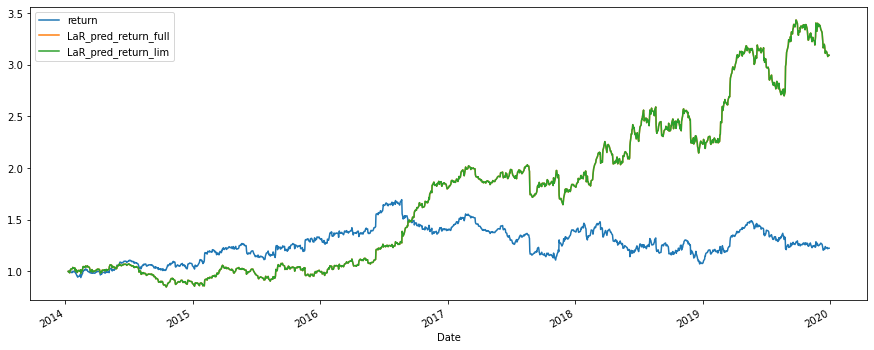

In [43]:
# plot predicted return vs actual return
X2['LaR_pred_full'] = laspipe2f.predict(X2[x2feat])
X2['LaR_pred_lim'] = laspipe2l.predict(X2[x2kbest])
X2['LaR_pred_return_full'] = X2['LaR_pred_full'] * X2['return']
X2['LaR_pred_return_lim'] = X2['LaR_pred_lim'] * X2['return']
X2[['return', 'LaR_pred_return_full', 'LaR_pred_return_lim']].cumsum().apply(np.exp).plot(figsize=(15, 6))

In [44]:
# return coefficients
print('Full feature set coefficients: ')
print(laspipe2f['regressor'].coef_)
print('\nLimited feature set coefficients: ')
print(laspipe2l['regressor'].coef_)

Full feature set coefficients: 
[[ 0.          0.         -0.06483411  0.          0.08977532  0.
   0.          0.          0.        ]]

Limited feature set coefficients: 
[[-0.06483047  0.08977303  0.        ]]


### Impact on coefficients

In [45]:
fcoefdf2 = pd.DataFrame({'None':logpipe2f['regressor'].coef_.flatten(), 'L1':laspipe2f['regressor'].coef_.flatten(), 'L2':ridpipe2f['regressor'].coef_.flatten()})

print('Full feature set coefficients: ')
fcoefdf2

Full feature set coefficients: 


,None,L1,L2
0,-0.341983,0.000000,-0.072023
1,-0.301147,0.000000,-0.064811
2,-0.354802,-0.064834,-0.128026
3,-0.262797,0.000000,-0.056941
4,-0.087277,0.089775,0.086482
5,0.057121,0.000000,0.025309
6,0.569646,0.000000,0.075326
7,-2.210076,0.000000,-0.034714
8,2.174881,0.000000,0.003948


In [46]:
lcoefdf2 = pd.DataFrame({'None':logpipe2l['regressor'].coef_.flatten(), 'L1':laspipe2l['regressor'].coef_.flatten(), 'L2':ridpipe2l['regressor'].coef_.flatten()})

print('Limited feature set coefficients: ')
lcoefdf2

Limited feature set coefficients: 


,None,L1,L2
0,-0.080698,-0.064830,-0.079484
1,0.140365,0.089773,0.134365
2,-0.038828,0.000000,-0.035650


What stands out here is that the Lasso regression approach eliminated all but two coefficients, indicating the majority of the features do not aid much in determining the following days direction. If the ordering is consistent then the two that remain are the 3 and 5 day returns, which would suggest the longer term trend is more indicative.

### Predicition quality

In [47]:
X2.tail(10)
#X2.to_csv('data/x2.csv')

,return,ret_1,ret_2,ret_3,ret_4,ret_5,m_1,m_5,sma,ema,...,LoR_pred_return_full,LoR_pred_return_lim,RR_pred_full,RR_pred_lim,RR_pred_return_full,RR_pred_return_lim,LaR_pred_full,LaR_pred_lim,LaR_pred_return_full,LaR_pred_return_lim
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-16,0.011070,-0.009413,-0.018947,-0.015488,-0.004422,-0.007202,-0.930740,-5.613571,101.024883,100.979047,...,0.011070,0.011070,1.0,1.0,0.011070,0.011070,1.0,1.0,0.011070,0.011070
2019-12-17,-0.004883,0.011070,-0.009413,-0.018947,-0.015488,-0.004422,1.095566,-3.771461,100.270590,100.612390,...,-0.004883,-0.004883,1.0,1.0,-0.004883,-0.004883,1.0,1.0,-0.004883,-0.004883
2019-12-18,0.009937,-0.004883,0.011070,-0.009413,-0.018947,-0.015488,-0.484772,-3.800552,99.510480,100.216205,...,0.009937,-0.009937,-1.0,-1.0,-0.009937,-0.009937,-1.0,-1.0,-0.009937,-0.009937
2019-12-19,0.013002,0.009937,-0.004883,0.011070,-0.009413,-0.018947,0.988930,-1.231300,99.264220,100.166298,...,-0.013002,-0.013002,-1.0,-1.0,-0.013002,-0.013002,-1.0,-1.0,-0.013002,-0.013002
2019-12-20,-0.007684,0.013002,0.009937,-0.004883,0.011070,-0.009413,1.308868,1.977852,99.659790,100.456086,...,-0.007684,0.007684,-1.0,-1.0,0.007684,0.007684,-1.0,-1.0,0.007684,0.007684
2019-12-23,-0.003284,-0.007684,0.013002,0.009937,-0.004883,0.011070,-0.775635,2.132957,100.086382,100.479517,...,-0.003284,-0.003284,1.0,1.0,-0.003284,-0.003284,1.0,1.0,-0.003284,-0.003284
2019-12-24,0.003669,-0.003284,-0.007684,0.013002,0.009937,-0.004883,-0.329628,0.707764,100.227934,100.414684,...,-0.003669,-0.003669,-1.0,-1.0,-0.003669,-0.003669,-1.0,-1.0,-0.003669,-0.003669
2019-12-26,-0.010659,0.003669,-0.003284,-0.007684,0.013002,0.009937,0.368408,1.560944,100.540123,100.458161,...,-0.010659,-0.010659,1.0,1.0,-0.010659,-0.010659,1.0,1.0,-0.010659,-0.010659
2019-12-27,0.004374,-0.010659,0.003669,-0.003284,-0.007684,0.013002,-1.066475,-0.494461,100.441231,100.224150,...,0.004374,0.004374,1.0,1.0,0.004374,0.004374,1.0,1.0,0.004374,0.004374


In [48]:
# generata classification reports
print('Logistic regresson with full feature set: ')
print(classification_report(X2['LoR_pred_full'], X2['return_sign']))
print('Logistic regresson with limited feature set: ')
print(classification_report(X2['LoR_pred_lim'], X2['return_sign']))
print('Ridge regression with full feature set: ')
print(classification_report(X2['RR_pred_full'], X2['return_sign']))
print('Ridge regression with limited feature set: ')
print(classification_report(X2['RR_pred_lim'], X2['return_sign']))
print('Lasso regression with full feature set: ')
print(classification_report(X2['LaR_pred_full'], X2['return_sign']))
print('Lasso regression with limited feature set: ')
print(classification_report(X2['LaR_pred_lim'], X2['return_sign']))

Logistic regresson with full feature set: 
              precision    recall  f1-score   support

        -1.0       0.39      0.48      0.43       578
         1.0       0.62      0.52      0.57       926

    accuracy                           0.51      1504
   macro avg       0.50      0.50      0.50      1504
weighted avg       0.53      0.51      0.51      1504

Logistic regresson with limited feature set: 
              precision    recall  f1-score   support

        -1.0       0.39      0.51      0.44       543
         1.0       0.66      0.54      0.59       961

    accuracy                           0.53      1504
   macro avg       0.52      0.53      0.52      1504
weighted avg       0.56      0.53      0.54      1504

Ridge regression with full feature set: 
              precision    recall  f1-score   support

        -1.0       0.39      0.51      0.44       550
         1.0       0.65      0.53      0.59       954

    accuracy                           0.52      150

X2 (full) Logistic Regression ROC plots:


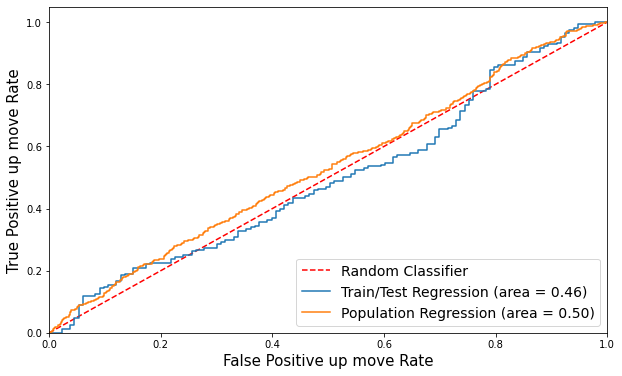

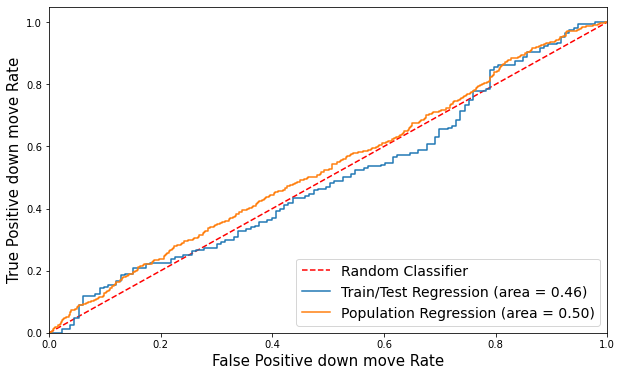

X2 (limited) Logistic Regression ROC plots:


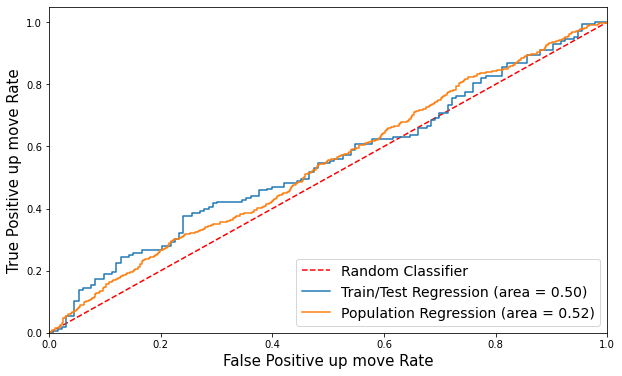

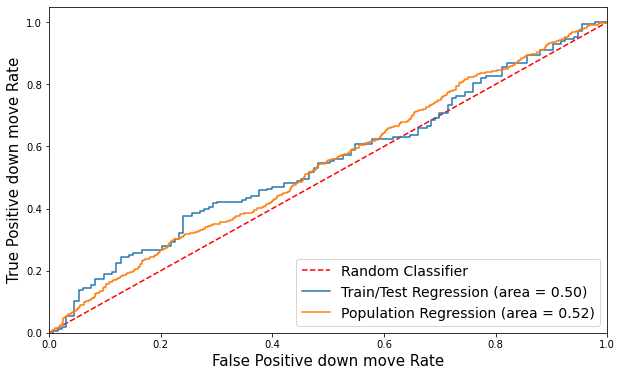

X2 (full) Ridge Regression ROC plots:


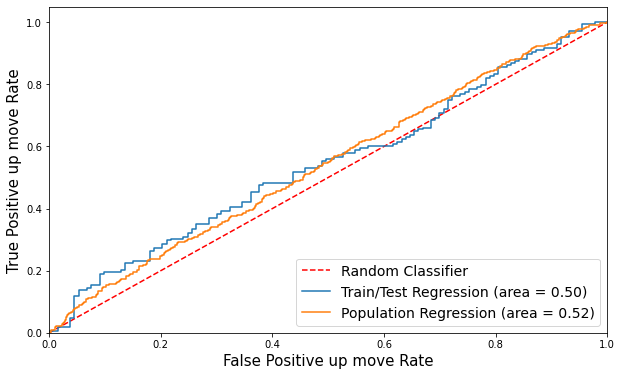

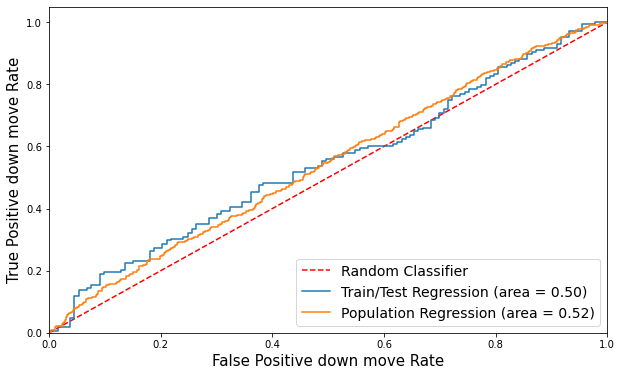

X2 (limited) Ridge Regression ROC plots:


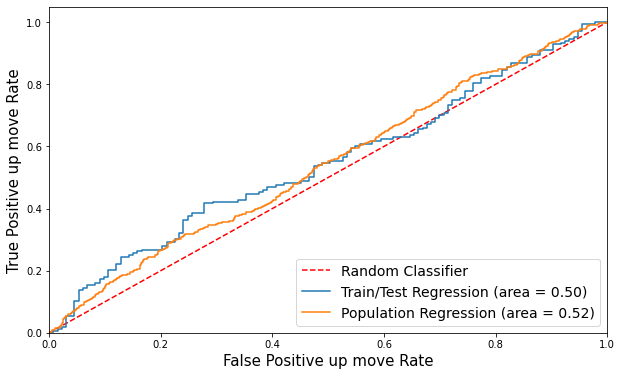

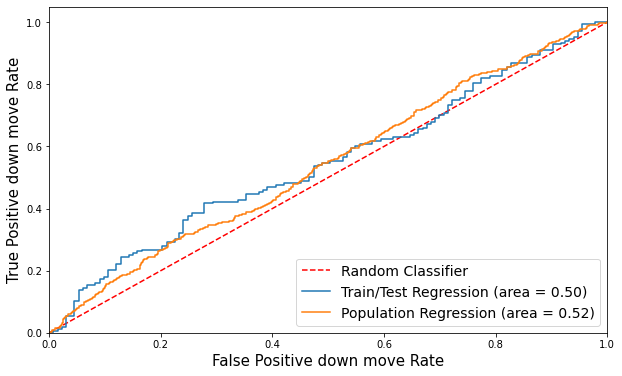

X2 (full) Lasso Regression ROC plots:


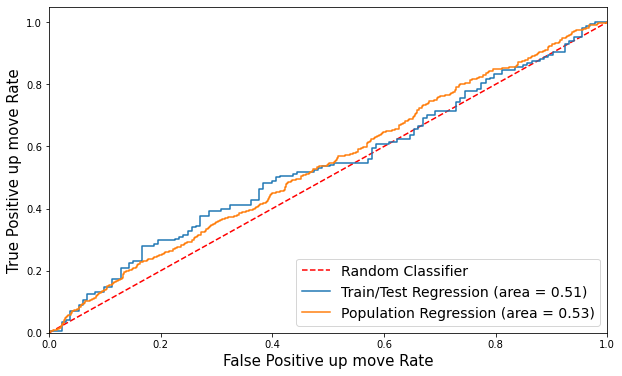

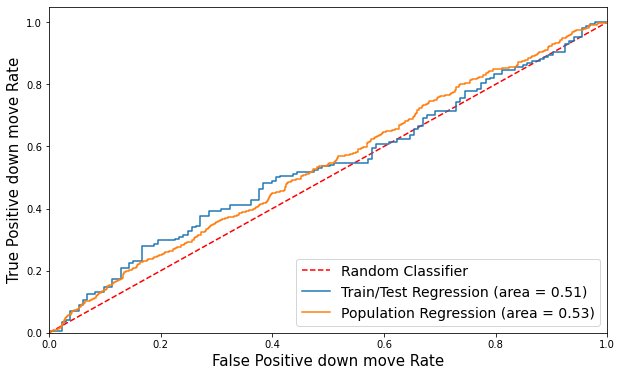

X2 (limited) Lasso Regression ROC plots:


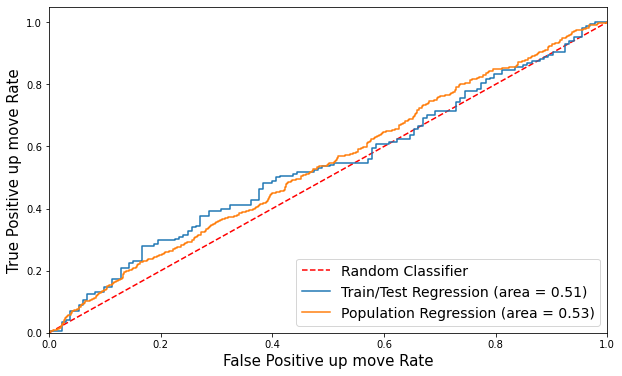

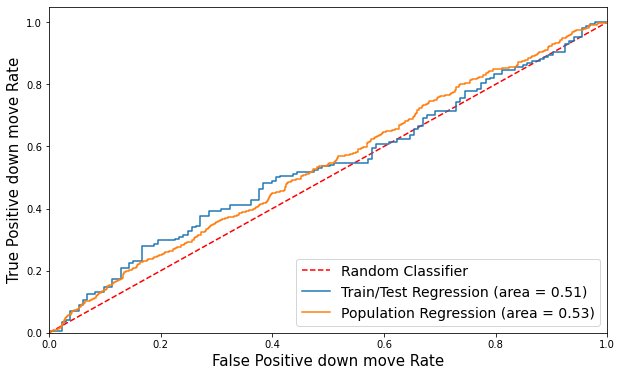

In [49]:
print('X2 (full) Logistic Regression ROC plots:')
plot_logistic_ROC(logpipe2f, X2_test_full, y2_test_full, X2[x2feat], X2['return_sign'], 1)
plot_logistic_ROC(logpipe2f, X2_test_full, y2_test_full, X2[x2feat], X2['return_sign'], 0)
print('X2 (limited) Logistic Regression ROC plots:')
plot_logistic_ROC(logpipe2l, X2_test_lim, y2_test_lim, X2[x2kbest], X2['return_sign'], 1)
plot_logistic_ROC(logpipe2l, X2_test_lim, y2_test_lim, X2[x2kbest], X2['return_sign'], 0)
print('X2 (full) Ridge Regression ROC plots:')
plot_logistic_ROC(ridpipe2f, X2_test_full, y2_test_full, X2[x2feat], X2['return_sign'], 1)
plot_logistic_ROC(ridpipe2f, X2_test_full, y2_test_full, X2[x2feat], X2['return_sign'], 0)
print('X2 (limited) Ridge Regression ROC plots:')
plot_logistic_ROC(ridpipe2l, X2_test_lim, y2_test_lim, X2[x2kbest], X2['return_sign'], 1)
plot_logistic_ROC(ridpipe2l, X2_test_lim, y2_test_lim, X2[x2kbest], X2['return_sign'], 0)
print('X2 (full) Lasso Regression ROC plots:')
plot_logistic_ROC(laspipe2f, X2_test_full, y2_test_full, X2[x2feat], X2['return_sign'], 1)
plot_logistic_ROC(laspipe2f, X2_test_full, y2_test_full, X2[x2feat], X2['return_sign'], 0)
print('X2 (limited) Lasso Regression ROC plots:')
plot_logistic_ROC(laspipe2l, X2_test_lim, y2_test_lim, X2[x2kbest], X2['return_sign'], 1)
plot_logistic_ROC(laspipe2l, X2_test_lim, y2_test_lim, X2[x2kbest], X2['return_sign'], 0)

(1)


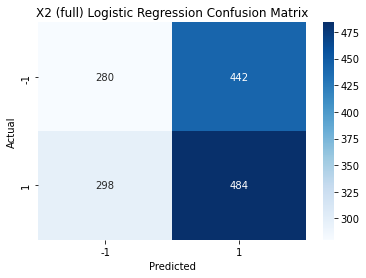

(2)


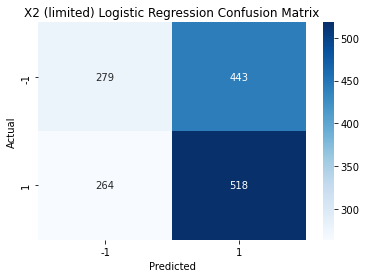

(3)


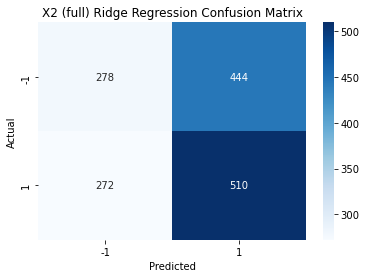

(4)


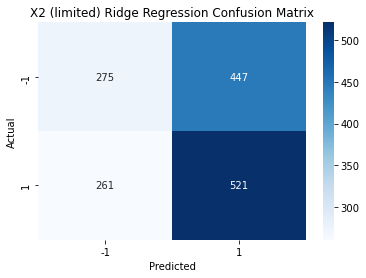

(5)


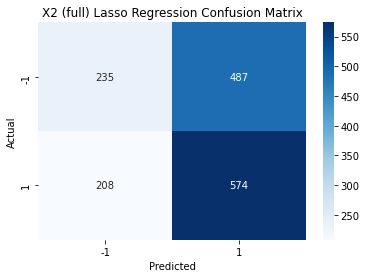

(6)


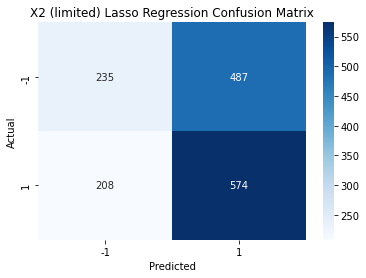

<module 'matplotlib.pyplot' from 'S:\\Program Files\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [50]:
# plot confusion matricies
print('(1)')
pltcm(X2['return_sign'],X2['LoR_pred_full'], 'X2 (full) Logistic Regression Confusion Matrix')
print('(2)')
pltcm(X2['return_sign'],X2['LoR_pred_lim'], 'X2 (limited) Logistic Regression Confusion Matrix')
print('(3)')
pltcm(X2['return_sign'],X2['RR_pred_full'], 'X2 (full) Ridge Regression Confusion Matrix')
print('(4)')
pltcm(X2['return_sign'],X2['RR_pred_lim'], 'X2 (limited) Ridge Regression Confusion Matrix')
print('(5)')
pltcm(X2['return_sign'],X2['LaR_pred_full'], 'X2 (full) Lasso Regression Confusion Matrix')
print('(6)')
pltcm(X2['return_sign'],X2['LaR_pred_lim'], 'X2 (limited) Lasso Regression Confusion Matrix')

### Findings

Stock 2 has a very similar story to stock 1. The plot of returns out perform the stock in all cases, however looking into the stats of the model show it to be no better than random.
The highest accuracy achieved was with Lasso regression, at 0.54, and is further shown in the ROC plots. With this stock the model predicted far more downward moves compared to stock one, as we'd expect given the stock price behavior, however false positives far outweight the true negatives as shown in the confusion matricies in all cases.
As before, perhaps there could be additional features that could improve the downward move prediciton but with the model picking up the longer term trend it was able to out perform the base stock price.

## K-fold cross-validation


K-fold cross-validation is the process of splitting the data into K number of groups, taking 1 group as the test set and training the model on the rest of the data. The model is evaluated withe the test set and then discarded. The process then repeats by taking another set as the test set. Finally the average of the scores is taken as the accuracy of the model.

In [51]:
# example of k-fold cross-validation with ridge regression model (limited feature set) on stock 1
kfold = KFold(n_splits=5, shuffle=False) 
print(kfold)
crossval = cross_val_score(ridpipe1f, X1_test_lim, y1_test_lim, cv=kfold, scoring='accuracy')
print("5-fold crossvalidation accuracy: %.4f" % (crossval.mean()))

KFold(n_splits=5, random_state=None, shuffle=False)
5-fold crossvalidation accuracy: 0.5713


## Transition probabilities


todo

### Stock 1 Ridge Regression

Text(0.5, 0, 'Probability')

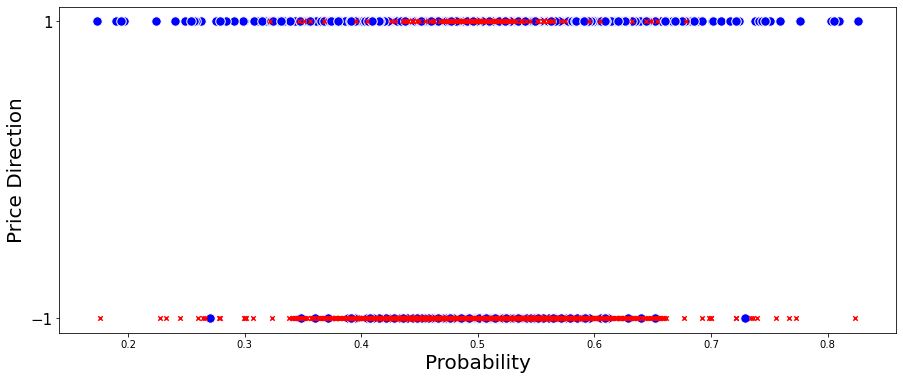

In [52]:
# get probabilities
prob1 = ridpipe1f.predict_proba(X1[x1feat])

# add probabilities to a copy of the dataset and filter for correct/incorrect predictions
x1 = X1.copy()
x1['probu'] = prob1[:,1]
x1['probd'] = prob1[:,0]
x1match = x1[x1['return_sign']==x1['RR_pred_full']]
x1unmatch = x1[x1['return_sign']!=x1['RR_pred_full']]

# plot
f, ax = plt.subplots(figsize=(15, 6))
ax.scatter( x1match['probu'], x1match['return_sign'], s=90, color='blue', edgecolor="white")
ax.scatter( x1match['probd'], x1match['return_sign'], s=90, color='blue', edgecolor="white")
ax.scatter( x1unmatch['probu'], x1unmatch['return_sign'], s=20, color='red', edgecolor="white", marker = "x")
ax.scatter( x1unmatch['probd'], x1unmatch['return_sign'], s=20, color='red', edgecolor="white", marker = "x")
plt.yticks([-1, 1], fontsize=15)
plt.ylabel('Price Direction', fontsize=20) 
plt.xlabel('Probability', fontsize=20)

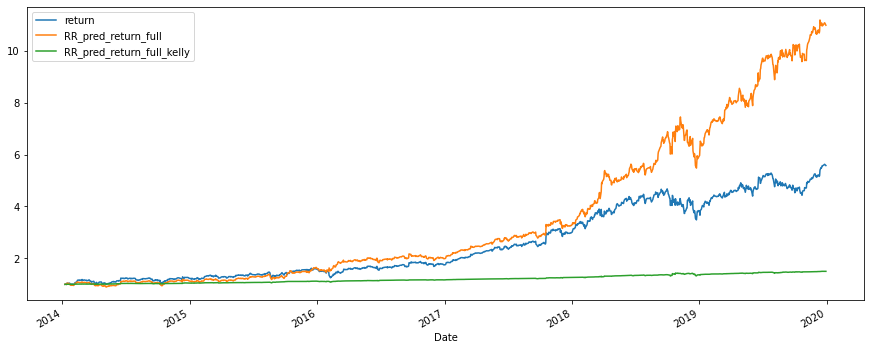

In [53]:
# calc return using Kelly bet
X1['RR_pred_return_full_kelly'] = (X1['RR_pred_full'] * X1['return']) * (2 * prob1[:,1] - 1)
X1[['return', 'RR_pred_return_full', 'RR_pred_return_full_kelly']].cumsum().apply(np.exp).plot(figsize=(15, 6))

Applying a Kelly optimal bet strategy has helped smooth out the graph and reduced losses that are seen in the 100% bet. As the probabilities are mostly around 0.5, very little money is invested.
In this case it has underperformed both 100% bets and holding the stock as the gains are also reduced - this being a stock with stable growth over the period means only a small fraction of that is being realised.

### Stock 2 Lasso Regression

Text(0.5, 0, 'Probability')

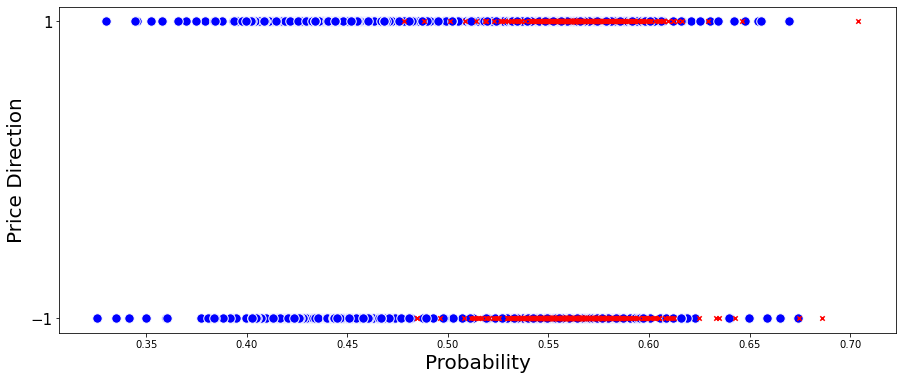

In [54]:
# get probabilities
prob2=laspipe1f.predict_proba(X2[x2feat])

# add probabilities to a copy of the dataset and filter for correct/incorrect predictions
x2 = X2.copy()
x2['probu'] = prob2[:,1]
x2['probd'] = prob2[:,0]
x2match = x2[x2['return_sign']==x2['RR_pred_full']]
x2unmatch = x2[x2['return_sign']!=x2['RR_pred_full']]

# plot
f, ax = plt.subplots(figsize=(15, 6))
ax.scatter( x2match['probu'], x2match['return_sign'], s=90, color='blue', edgecolor="white")
ax.scatter( x2match['probd'], x2match['return_sign'], s=90, color='blue', edgecolor="white")
ax.scatter( x2unmatch['probu'], x2unmatch['return_sign'], s=20, color='red', edgecolor="white", marker = "x")
plt.yticks([-1, 1], fontsize=15)
plt.ylabel('Price Direction', fontsize=20) 
plt.xlabel('Probability', fontsize=20)

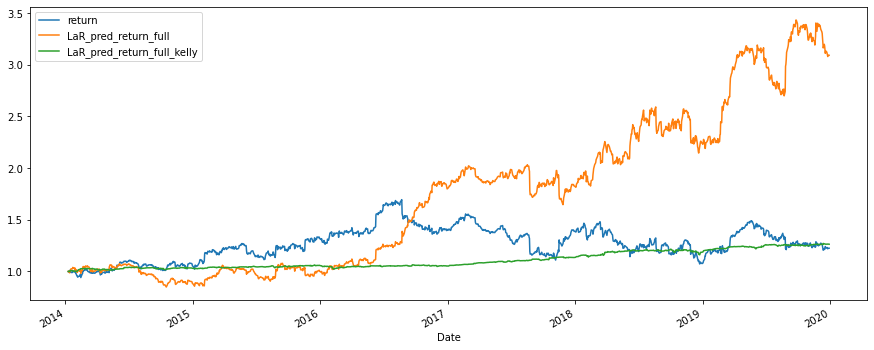

In [55]:
# calc return using Kelly bet
X2['LaR_pred_return_full_kelly'] = (X1['LaR_pred_full'] * X1['return']) * (2 * prob2[:,1] - 1)
X2[['return', 'LaR_pred_return_full', 'LaR_pred_return_full_kelly']].cumsum().apply(np.exp).plot(figsize=(15, 6))

Again,applying a Kelly optimal bet strategy has helped smooth out the graph but in this case, as it is a failing stock, it has been able to give stable growth even as the stock itself is falling. As the majority of probabilities are clustered around 0.5, very little is invested meaning gains are heavily reduced.